In [1]:
#Style Transfer for Arbitrary Styles
#https://www.tensorflow.org/tutorials/generative/style_transfer


In [3]:
import functools
import os

import matplotlib.pylab as plt
from matplotlib import gridspec
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available('GPU'))

TF Version:  2.12.0
TF-Hub version:  0.13.0
Eager mode enabled:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available:  False


In [10]:
#Define image loading and visualization functions

def crop_center(image):
    #Returns a cropped square image.
    shape = image.shape # get shape of image
    new_shape = min(shape[1], shape[2]) # get smallest dimension of image
    offset_y = max(shape[1] - shape[2], 0) // 2 #// is floor division operator
    offset_x = max(shape[2] - shape[1], 0) // 2 
    image = tf.image.crop_to_bounding_box(image, offset_y, offset_x, new_shape, new_shape)
    return image

@functools.lru_cache(maxsize=None) #cache results of function calls for faster execution
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
    #Loads and preprocesses images.
    #cache image file locally
    image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url) #get_file downloads a file from a URL if it not already in the cache
    #load and convert to float32 numpy array, add batch dimension, normalize to range [0, 1]
    img = tf.io.decode_image( #decode image into tensor
        tf.io.read_file(image_path), #read image file
        channels=3, #number of color channels to decode
        dtype=tf.float32)[tf.newaxis, ...] #add batch dimension and convert to float32 numpy array
    img = crop_center(img) #crop image to square
    img = tf.image.resize(img, image_size, preserve_aspect_ratio=True) #resize image to image_size while preserving aspect ratio
    return img

def show_n(images, titles=('',)):
    n = len(images) #number of images
    image_sizes = [image.shape[1] for image in images] #get size of each image in images
    w = (image_sizes[0]*6)//320 #width of each image in inches (6 inches is the default width of a matplotlib figure)
    plt.figure(figsize=(w* n, w)) #create figure with width w*n and height w
    gs = gridspec.GridSpec(1, n, width_ratios=image_sizes) #create grid of n columns with width of each column equal to the size of the corresponding image
    for i in range(n):
        plt.subplot(gs[i]) #select subplot i of grid gs
        plt.imshow(images[i][0], aspect='equal') #show image in subplot i of grid gs with aspect ratio equal to 1 (equal scaling of x and y)
        plt.axis('off') #turn off axis
        plt.title(titles[i] if len(titles) > i else '') #set title of subplot i of grid gs to titles[i] if titles has more than i elements, otherwise set title to ''
    plt.show() #show figure

11403121/11403121 [==============================] - 1s 0us/step


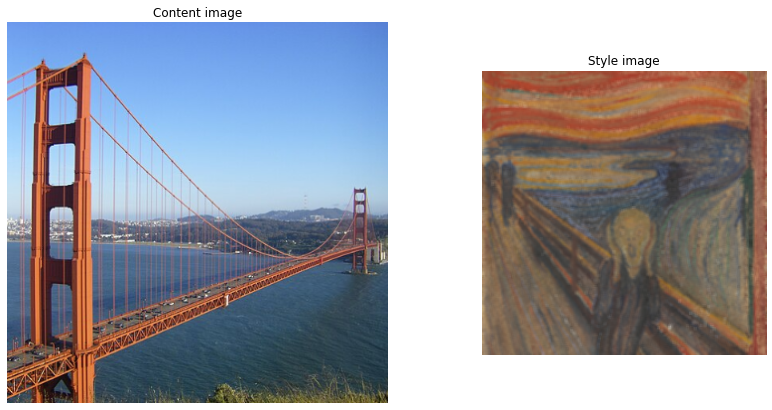

In [19]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [20]:
#import TF-Hub module
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2' #handle to TF-Hub module
hub_module = hub.load(hub_handle) #load module

In [13]:
#the signature of this hub module for image stylization is:

In [22]:
outputs = hub_module(content_image, style_image) #outputs is a list of tensors 
stylized_image = outputs[0] #get first tensor in outputs

In [15]:
#Where content_image, style_image, and stylized_image are expected to be 4-D Tensors with shapes [batch_size, image_height, image_width, 3], with values ranging from 0 to 1.
#The output is a stylized image with shape [batch_size, image_height, image_width, 3], with values also ranging from 0 to 1.
#the shapes of content_image and style_image don't have to match. The output image shape will match the shape of the content image.

In [16]:
#Demonstrate image stylization
#Stylize image using arbitrary style image
#This is pretty slow within a Colab notebook environment and will take a couple minutes.

In [23]:
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

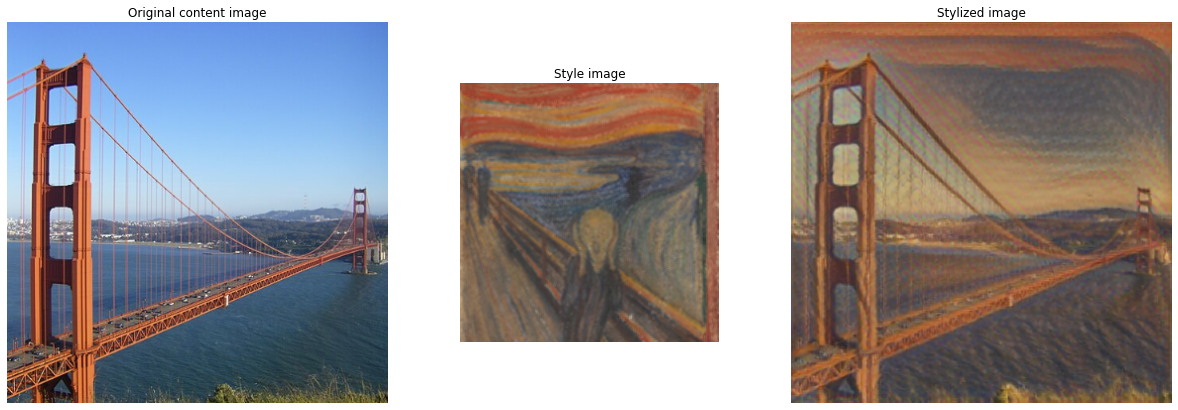

In [24]:
#Visualize input images and the generated stylized image.
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

In [25]:
# @title To Run: Load more images { display-mode: "form" }

content_urls = dict(
  sea_turtle='https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg',
  tuebingen='https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg',
  grace_hopper='https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg',
  )
style_urls = dict(
  kanagawa_great_wave='https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
  kandinsky_composition_7='https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
  hubble_pillars_of_creation='https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg',
  van_gogh_starry_night='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
  turner_nantes='https://upload.wikimedia.org/wikipedia/commons/b/b7/JMW_Turner_-_Nantes_from_the_Ile_Feydeau.jpg',
  munch_scream='https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
  picasso_demoiselles_avignon='https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg',
  picasso_violin='https://upload.wikimedia.org/wikipedia/en/3/3c/Pablo_Picasso%2C_1911-12%2C_Violon_%28Violin%29%2C_oil_on_canvas%2C_Kr%C3%B6ller-M%C3%BCller_Museum%2C_Otterlo%2C_Netherlands.jpg',
  picasso_bottle_of_rum='https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg',
  fire='https://upload.wikimedia.org/wikipedia/commons/3/36/Large_bonfire.jpg',
  derkovits_woman_head='https://upload.wikimedia.org/wikipedia/commons/0/0d/Derkovits_Gyula_Woman_head_1922.jpg',
  amadeo_style_life='https://upload.wikimedia.org/wikipedia/commons/8/8e/Untitled_%28Still_life%29_%281913%29_-_Amadeo_Souza-Cardoso_%281887-1918%29_%2817385824283%29.jpg',
  derkovtis_talig='https://upload.wikimedia.org/wikipedia/commons/3/37/Derkovits_Gyula_Talig%C3%A1s_1920.jpg',
  amadeo_cardoso='https://upload.wikimedia.org/wikipedia/commons/7/7d/Amadeo_de_Souza-Cardoso%2C_1915_-_Landscape_with_black_figure.jpg'
)

content_image_size = 384
style_image_size = 256
content_images = {k: load_image(v, (content_image_size, content_image_size)) for k, v in content_urls.items()}
style_images = {k: load_image(v, (style_image_size, style_image_size)) for k, v in style_urls.items()}
style_images = {k: tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME') for k, style_image in style_images.items()}

66306/66306 [==============================] - 0s 0us/step


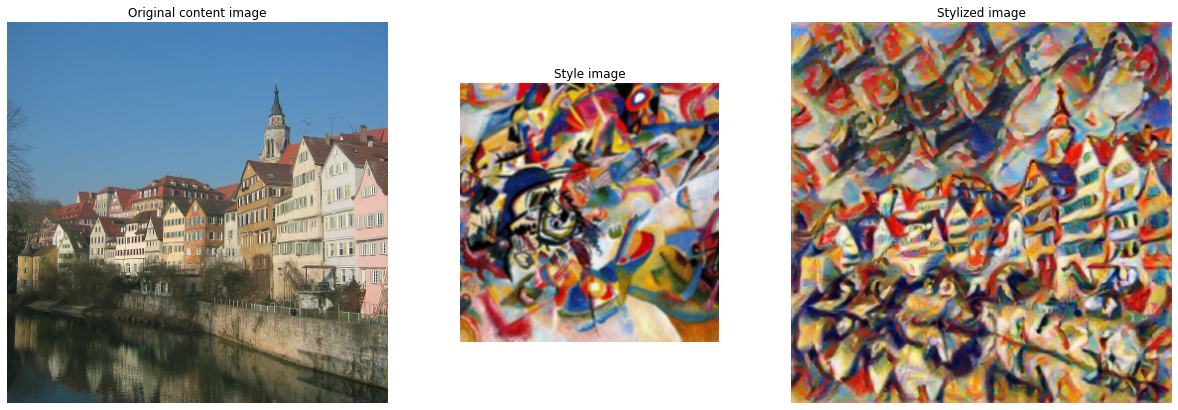

In [32]:
#Specify content and style images
#Choose a style image and a content image:
content_image = 'tuebingen' # @param ['sea_turtle', 'tuebingen', 'grace_hopper']
style_name = 'kandinsky_composition_7' # @param []

stylized_image = hub_module(tf.constant(content_images[content_image]),
                             tf.constant(style_images[style_name]))[0]
show_n([content_images[content_image], style_images[style_name], stylized_image],
        titles=['Original content image', 'Style image', 'Stylized image'])